# Construcción de una Red Neuronal desde cero
A través de este tutorial, se va a construir una Red Neuronal Artificial (RNA) explicando de forma teórica los diferentes elementos necesarios para la construcción y entrenamiento del modelo. Además, se pondrá en práctica la red para evaluar su correcto funcionamiento.

# Índice de contenidos
- [1 - Inicialización de capas](#1)
- [2 - Inicialización de parámetros](#2)
- [3 - Implementar "forward propagation"](#3)
- [4 - Computación del coste](#4)
- [5 - Implementación del "backward propagation"](#5)
- [6 - Actualización de parámetros (gradient descent)](#6)
- [7 - Entrenamiento del modelo](#7)
- [8 - Predicción](#8)

# 1.- Instalación de librerías
En primer lugar, se instalan e importan todas las librerías necesarias para la realización de la implementación.

## 1.1.- Instalación de las librerías
Se va a emplear 'numpy' y 'matplotlib':

In [3]:
%pip install numpy
%pip install matplotlib


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-08-04 13:37:47.551609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 13:37:47.568898: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 13:37:47.573822: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-04 13:37:47.586957: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


I0000 00:00:1722778669.990311     560 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722778670.000742     560 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722778670.000799     560 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.


## 1.2.- Inicialización de librerías
Una vez instaladas, se inicializan las librerías:

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## 1.3.- Carga del conjunto de datos
Se procede a cargar el conjunto de datos CIFAR-10:

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

A través de la extracción de las imágenes de la librería de Tensorflow, se distinguirá entre conjunto de datos de entrenamiento (x_train) y sus respectivas etiquetas (y_train), y datos de test.

In [7]:
print("El tamaño del conjunto de datos de entrenamiento es ", x_train.shape)
print("El tamaño del las etiquetas del conjunto de entrenamiento es ", y_train.shape, "\n")
print("El tamaño del conjunto de datos de entrenamiento es ", x_test.shape)
print("El tamaño del las etiquetas del conjunto de entrenamiento es ", y_test.shape)

El tamaño del conjunto de datos de entrenamiento es  (50000, 32, 32, 3)
El tamaño del las etiquetas del conjunto de entrenamiento es  (50000, 1) 

El tamaño del conjunto de datos de entrenamiento es  (10000, 32, 32, 3)
El tamaño del las etiquetas del conjunto de entrenamiento es  (10000, 1)


A través de la documentación, se identifican las diferentes etiquetas existentes en el conjunto de datos. Estas etiquetas equivalen a:
* 0: avión.
* 1: coches.
* 2: pájaro.
* 3: gato.
* 4: ciervo.
* 5: perro.
* 6: rana.
* 7: caballo.
* 8: barco.
* 9: camión.

In [8]:
etiquetas = ['Avión', 'Coche','Pajaro', 'Gato', 'Ciervo', 'Perro', 'Rana', 'Caballo', 'Barco', 'Camion']

Conociendo el tamaño del dataset, visualizo un primer ejemplo de datos:

In [9]:
def visualizar_imagen(conjunto, etiqueta, index_image):
    plt.figure(figsize=(5,5))
    
    # Eliminar las etiquetas de los ejes
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(etiquetas[etiqueta[index_image][0]])
    plt.imshow(conjunto[index_image])
    plt.show()

Se usa el método:

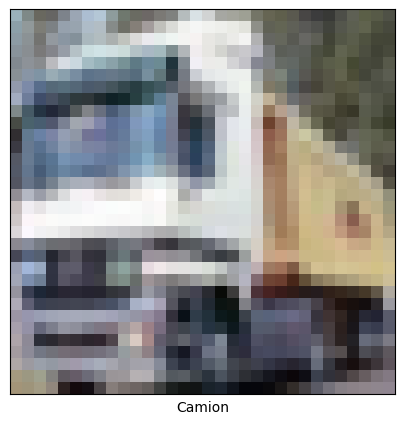

In [10]:
visualizar_imagen(x_train, y_train, 1)

# 2.- Inicialización de capas
Este método nos permite definir la estructura de la red neuronal que vamos a construir. 

In [14]:
def init_layers(X, Y, num_hidden_layers, num_hidden_units):
    """
    Este método permite definir la estructura de la red neuronal, especificando el número de neuronas en la capa de entrada (que viene dada por el tamaño del dataset utilizado),
    el número de capas ocultas especificado por parámetro de entrada, el número de neuronas en cada una de estas capas ocultas y finalmente, el número de neuronas en la capa de
    salida (especificado como el tamaño de la variable objetivo).

    Se entiende por tanto que se está construyendo una Red Neuronal Profunda donde tocas las capas ocultas tienen el mismo número de neuronas.

    Variables de entrada:
    X -- conjunto de datos de entrada (tamaño de entrada, número de ejemplos)
    Y -- etiquetas (tamaño de salida, número de ejemplos)
    
    Variables de salida:
    input_units -- número de neuronas en la capa de entrada (equivalente al número de variables de entrada)
    hidden_units -- número de neuronas en las capas ocultas
    output_units -- número de neuronas en la capa de salida
    """
    # Defino un array que almacene la estructura de capas de la red
    dim_layers = []

    # Defino el número de neuronas en la capa de entrada
    input_units = X.shape[1]*X.shape[2]

    # Añado la primera capa, en este caso, la capa de entrada
    dim_layers.append(input_units)

    hidden_layers = num_hidden_layers
    hidden_units = num_hidden_units

    # Itero sobre el número de capas ocultas
    for i in range(0,hidden_layers):
        dim_layers.append(hidden_units[i])

    # Finalmente, se añade la capa de salida
    output_units = Y.shape[1]
    dim_layers.append(output_units)

    return dim_layers

Utilizamos el método para inicializar la estructura de la red:

In [15]:
rna = init_layers(X = x_train, Y = y_train, num_hidden_layers = 4, num_hidden_units = [200, 300, 300, 200])

Visualizo la estructura definida:

In [16]:
rna

[1024, 200, 300, 300, 200, 1]

# 3.- Inicialización de parámetros
Este método nos permite inicializar los parámetros para una red neuronal de `l` capas.

In [17]:
def init_parameters(dims_layers):
    """
    Esta función nos permitirá inicializar los parámetros de la Red Neuronal con la estructura definida en la función anterior.

    Variables de entrada:
    dims_layers -- consiste en las dimensiones de la red.

    Variables de salida
    parameters -- consiste en el conjunto de parámetros inicializados en la red
    """

    # Se crea el diccionario para almacenar los parámetros
    parameters = {}

    for num_capa in range(1, len(dims_layers)):
        # Para cada capa se debe de crear la matriz de pesos y el sesgo correspondiente.
        parameters['W' + str(num_capa)] = np.random.rand(dims_layers[num_capa], dims_layers[num_capa-1])
        parameters['b' + str(num_capa)] = np.random.rand(dims_layers[num_capa], 1)

    # Devuelvo los parámetros inicializados
    return parameters

Probamos el método:

In [18]:
parameters = init_parameters(rna)

Compruebo la salida:

In [34]:
for i in range(1, len(rna)):
    print("DIMENSIONES DE LA CAPA ", i)
    print("Matriz de pesos con dimensiones: ", parameters['W' + str(i)].shape)
    print("Matriz de bias/sesgo con dimensiones: ", parameters['b' + str(i)].shape, "\n")

DIMENSIONES DE LA CAPA  1
Matriz de pesos con dimensiones:  (200, 1024)
Matriz de bias/sesgo con dimensiones:  (200, 1) 

DIMENSIONES DE LA CAPA  2
Matriz de pesos con dimensiones:  (300, 200)
Matriz de bias/sesgo con dimensiones:  (300, 1) 

DIMENSIONES DE LA CAPA  3
Matriz de pesos con dimensiones:  (300, 300)
Matriz de bias/sesgo con dimensiones:  (300, 1) 

DIMENSIONES DE LA CAPA  4
Matriz de pesos con dimensiones:  (200, 300)
Matriz de bias/sesgo con dimensiones:  (200, 1) 

DIMENSIONES DE LA CAPA  5
Matriz de pesos con dimensiones:  (1, 200)
Matriz de bias/sesgo con dimensiones:  (1, 1) 



# 4.- Implementación de 'forward propagation'
Para implementar la propagación hacia delante, se deben de realizar los siguientes cálculos:
* Cálculo de los parámetros pre-activación.
* Cálculo de la activación de las neuronas.


## 4.1.- Parámetros pre-activación
Este método se encarga de calcular los parámetros que se introducen en la función de activación de la neurona. La ecuación que se emplea es:
$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$
donde ${[l]}$ es el número de capa; $W^{[l]}$ son los pesos actuales de la capa actual; $A^{[l-1]}$ es la activación de la capa anterior; $b^{[l]}$ es el bias de la capa.

In [ ]:
def pre_activation(A, W, b):
    """_summary_
    Esta función permite calcular los parámetros pre-activacion de la neurona.
    
    Args:
        A (_type_): consiste en las activaciones obtenidas en la capa anterior.
        W (_type_): consiste en los pesos actuales de la capa.
        b (_type_): consiste en el sesgo actual de la capa.
    """

    # Obtengo los parámetros de pre-activación
    Z = np.dot(W,A) + b

    # Creo una tupla de Python guardada en cache para acelerar el entrenamiento de la red, ya que estos parámetros se usarán más en adelante
    pre_activation_params = (A, W, b)

    return Z, pre_activation_params

## 4.2.- Activación de la capa
Este método se encargará de calcular la activación de la neurona ante los parámetros pre-activación. Son múltiples las opciones que podemos emplear para realizar este paso. A continuación, explicamos y definimos las más comunes:
* **Sigmoid**: 
* **ReLU**:
* **Softmax**: 
* **Leaky ReLU**: 
* **Tanh**: 

### 4.2.1.- Sigmoid
La función sigmoidal sigue la siguiente fórmula matemática:


In [ ]:
def sigmoid(z):
    activation = 1 / (1 +  np.exp(-z))

    return activation

### 4.2.2.- ReLU
La función ReLU sigue la siguiente fórmula matemática:

In [ ]:
def relu(z):
    activation = max(0,z)

    return activation

### 4.2.3.- Softmax
La función Softmax sigue la siguiente fórmula matemática:

In [ ]:
def relu(z):
    max_z = np.max(z)
    exp = np.exp(z-max_z)
    activation = exp/max_z

    return activation

### 4.2.4.- Leaky ReLU
La función Leaky ReLU sigue la siguiente fórmula matemática:

In [ ]:
def leaky_relu(z):
    activation = max(0.01*z,z)

    return activation

### 4.2.5.- Tanh
La función Tanh sigue la siguiente fórmula matemática:

In [ ]:
def tanh(z):
    activation = np.tanh(z)

    return activation

## 4.3.- Cálculo de la activación de la capa
Empleando los métodos anteriores, se procede a calcular la activación de la capa:

In [ ]:
def forward_activation(dataset, parameters):
    """_summary_
    Función que permite calcular la activación de la capa
    """

    # Almaceno los resultados en la caché para acelerar el entrenamiento de la red
    caches = []

    # Número de capas ocultas
    hidden_layers = len(parameters)/2

    # Para la primera capa, las funciones de activación son los datos de entrada
    A = dataset

    # Calculo la activación de las capas ocultas
    for num_layer in range(1, hidden_layers):
        Z, pre_activation_params = pre_activation(A, parameters['W' + str(num_layer)], parameters['b' + str(num_layer)])
        A = relu(Z)
        caches.append(A)

    # Calculo la activación de la capa final
    Z = pre_activation(A, parameters['W' + str(hidden_layers)], parameters['b' + str(hidden_layers)])
    AL = sigmoid(Z)
    caches.append(cache)
    
    return 

# 5.- Computación de la pérdida
En este punto, ya tenemos computada la activación de cada capa por lo que tan sólo quedaría computar el coste. El coste define el error existente entre las predicciones del modelo y las etiquetas reales del conjunto de datos. Para asegurarnos de que nuestro modelo está aprendiendo correctamente, el coste debería de reducirse en cada etapa del entrenamiento.

Procedemos por tanto a definir algunas de las funciones de pérdida (que son las funciones que calculan el 'coste' sobre un conjunto de datos) más comunes:
* **Cross-entropy**: 
* **Log Loss**:

In [ ]:
def cost_function(predictions, Y):
    """_summary_
    Función que permite calcular el error entre las predicciones del modelo y las etiquetas correctas.

    Args:
        predictions (_type_): _description_
        Y (_type_): _description_
    """
    # Obtengo el número de ejemplos
    num_examples = Y.shape[1]

    # Calculo la función de pérdida
    cost = -(1/num_examples) * np.sum( Y * np.log(predictions) + (1-Y) * np.log(1-predictions))

    return cost

# 6.- Implementación del backward propagation

# 7.- Actualización de parámetros (Gradient Descent)

# 8.- Entrenamiento del modelo

# 9.- Predicción

# 10.- Conclusión